## Урок 3, домашнее задание

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:

- Возраст
- Рост
- Вес
- Пол

Результаты измерения:

- Артериальное давление верхнее и нижнее
- Холестерин
- Глюкоза

Субъективные признаки:

- Курение
- Употребление Алкоголя
- Физическая активность
- Возраст дан в днях. 

Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [131]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
import itertools

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [133]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [134]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:

gender, cholesterol применим OHE-кодирование
age, height, weight, ap_hi, ap_lo - standardScaler
gluc, smoke, alco, active - оставим пока как есть

In [135]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [136]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Приведем необходимые функции для построения кривой roc auc curve и матрицы ошибок.

In [137]:
def roc_auc_plot(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

Создадим датафрейм для хранения метрик по различным методам классификации.

In [138]:
final_stats = pd.DataFrame(columns = ['precision', 'recall','f-score','roc_auc'])

Добавим классификатор и запустим кросс-валидацию

### Классификация с использованием логистической регрессии

In [139]:
classifier_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_logreg, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_logreg.fit(X_train, y_train)
y_score = classifier_logreg.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score и roc auc score.

In [140]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier_logreg.predict_proba(X_test)[:,1])
final_stats.loc['Log_reg'] = [precision[ix], recall[ix], fscore[ix], roc_auc]
print(final_stats.loc['Log_reg'])

precision    0.647431
recall       0.837558
f-score      0.730323
roc_auc      0.784035
Name: Log_reg, dtype: float64


Нарисуем roc auc кривую

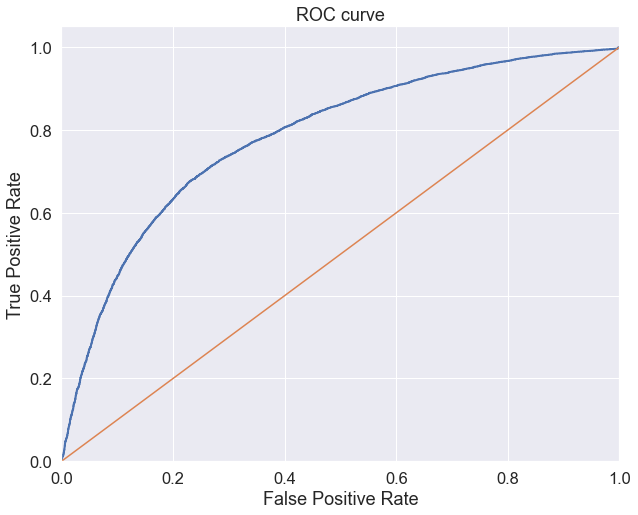

In [141]:
roc_auc_plot(y_test, y_score)

In [142]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_logreg.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_logreg.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230663


Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


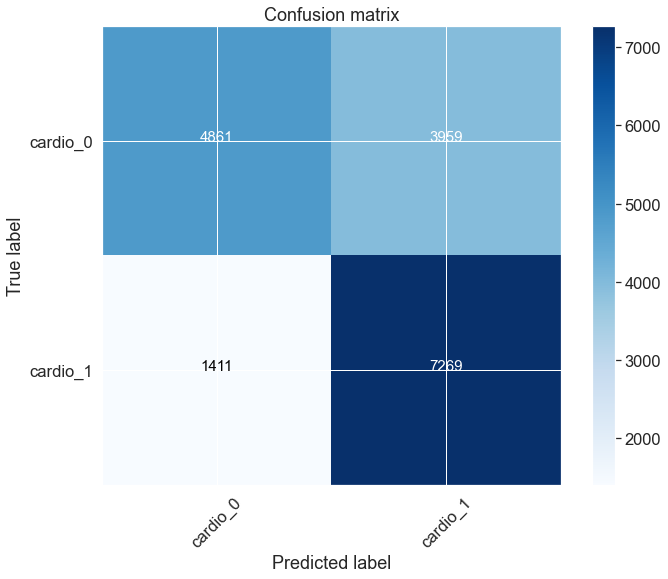

In [143]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.show()

Посчитаем FPR, TPR

In [144]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

### Классификация с использованием случайного леса

In [145]:
classifier_randfor = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=5, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_randfor, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_randfor.fit(X_train, y_train)
y_score = classifier_randfor.predict_proba(X_test)[:, 1]

CV score is 0.7946427878931981+-0.006728681298591317


Посчитаем precision/recall/f_score и roc auc score.

In [146]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier_randfor.predict_proba(X_test)[:,1])
final_stats.loc['Rand_for'] = [precision[ix], recall[ix], fscore[ix], roc_auc]
print(final_stats.loc['Rand_for'])

precision    0.675382
recall       0.815438
f-score      0.738831
roc_auc      0.795859
Name: Rand_for, dtype: float64


Нарисуем roc auc кривую

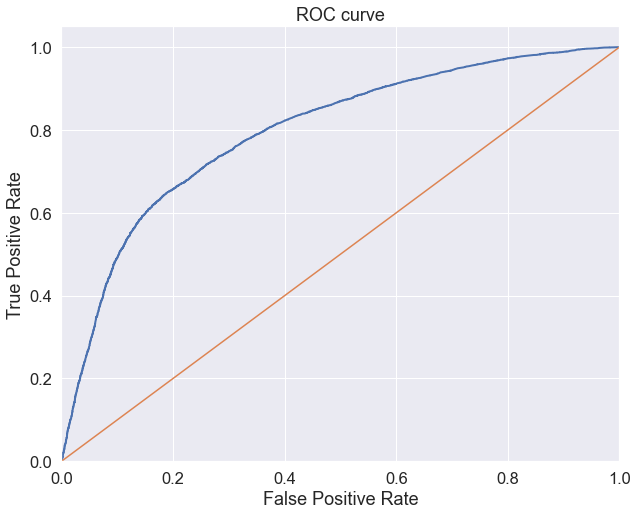

In [147]:
roc_auc_plot(y_test, y_score)

In [148]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_randfor.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_randfor.predict_proba(X_test)[:,1])))

roc auc score: 0.7958588043512336
log loss score: 0.557608070471717


Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[5418 3402]
 [1603 7077]]


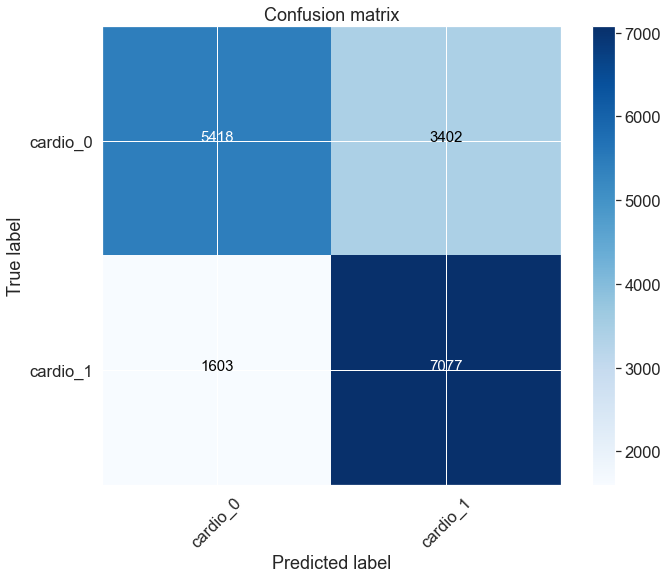

In [149]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.show()

Посчитаем FPR, TPR

In [150]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8153225806451613, 0.38571428571428573, 0.6142857142857143)

FPR получился лучше, чем в предыдущей модели - 0,38 вместо 0,45.

## Классификация с использованием метода KNN

In [151]:
classifier_knn = Pipeline([
    ('features',feats),
    ('classifier', KNeighborsClassifier()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_knn, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_knn.fit(X_train, y_train)
y_score = classifier_knn.predict_proba(X_test)[:, 1]

CV score is 0.6919218138274713+-0.007083802929940452


Посчитаем precision/recall/f_score и roc auc score.

In [152]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier_knn.predict_proba(X_test)[:,1])
final_stats.loc['KNN'] = [precision[ix], recall[ix], fscore[ix], roc_auc]
print(final_stats.loc['KNN'])

precision    0.588468
recall       0.821889
f-score      0.685863
roc_auc      0.694088
Name: KNN, dtype: float64


Нарисуем roc auc кривую

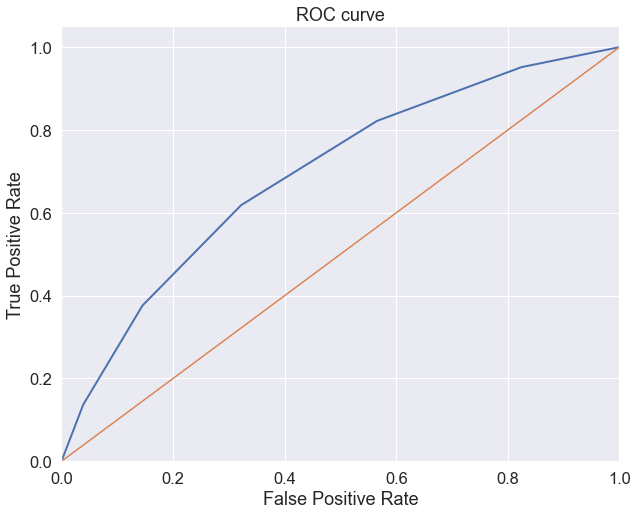

In [153]:
roc_auc_plot(y_test, y_score)

In [154]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_knn.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_knn.predict_proba(X_test)[:,1])))

roc auc score: 0.6940883204280176
log loss score: 2.0495594233752303


Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[5979 2841]
 [3311 5369]]


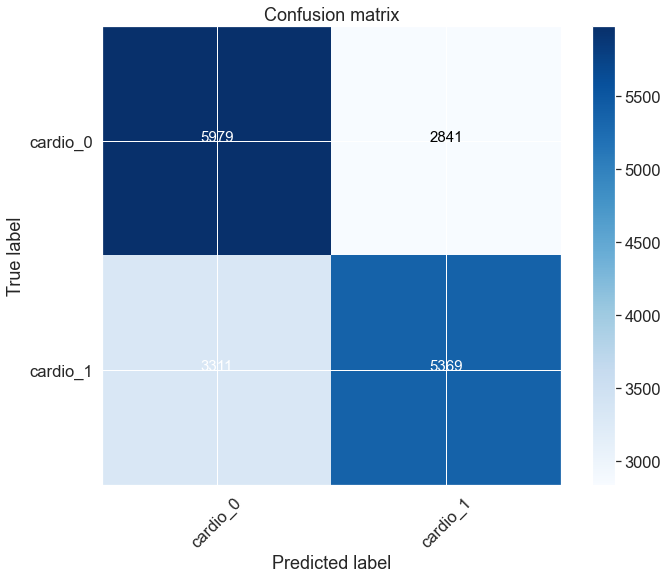

In [155]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.show()

Посчитаем FPR, TPR

In [156]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.6185483870967742, 0.322108843537415, 0.677891156462585)

False Positive Rate получился еще ниже ~ 0.32.

Сравним результаты, полученные с помощью разных моделей.

In [157]:
final_stats

,precision,recall,f-score,roc_auc
Log_reg,0.647431,0.837558,0.730323,0.784035
Rand_for,0.675382,0.815438,0.738831,0.795859
KNN,0.588468,0.821889,0.685863,0.694088


Как видим, модель Random Forest дает наилучшие результаты по всем метрикам кроме Recall. В то же время возможно, что как раз в данной задаче метрика recall имеет наибольшую важность, так как минимизирует число "упущенных" больных (то есть число пациентов, больных ССЗ, для которых получен результат "не болен"). Так что стоило бы еще поработать над моделями - например, провести GridSearchCV для подбора глобальных параметров Random Forest.

## Вопрос 5

В приведенном примере явно лучше  первая модель. 
Обычно ищется какой-то баланс между повышением метрики precision или метрики recall, поскольку между ними часто есть обратная взаимосвязь (улучшение precision приводит к ухудшению recall, и наоборот). А в данном примере метрика recall у обеих моделей совпадает (равна 90/(90 + 10) = 0,9), но метрика precision значительно лучше у первой модели (равна 90/(90 + 10) = 0,9 против значения 90/(90 + 910) = 0,09 у второй модели.
Поэтому можно предположить,  что метрика precision_recall_curve больше подходит для случая сильного дисбаланса классов, чем roc_auc_curve, поскольку как раз явно опирается на precision и recall.